## Imports

In [1]:
import pickle
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from scipy import stats


## Config

In [37]:
RETRAIN_SVM = False
SVM_BEST_PARAMS = {
    "C": 100,
    "kernel": "poly"
}
SVM_MODEL_FILE = "refitted_svm.pickle"

RETRAIN_LOGREG = False
LOGREG_BEST_PARAMS = {
    "C": 0.1,
    "penalty": "l1",
    "solver": "saga",
    "max_iter": 10_000
}
LOGREG_MODEL_FILE = "refitted_log_reg.pickle"
IMG_SIZE = 28

RETRAIN_INK = True
LOGREG_INK_MODEL_FILE = "ink_log_reg.pickle"

RETRAIN_ANGLE = True
LOGREG_ANGLE_MODEL_FILE = "angle_log_reg.pickle"

RETRAIN_BOTH = True
LOGREG_BOTH_MODEL_FILE = "both_log_reg.pickle"

## Data processing

In [3]:
mnist = pd.read_csv("mnist.csv").values

In [4]:
digits = mnist[:, 1:]
labels = mnist[: , 0]

In [5]:
var_thr = VarianceThreshold(threshold = 0)
clean_digits = var_thr.fit_transform(digits)
scaler = StandardScaler()  
scaled_digits = scaler.fit_transform(clean_digits)
scaled_with_label = np.column_stack((labels, scaled_digits))

In [6]:
np.random.seed(123)
test_indices = np.random.choice(scaled_with_label.shape[0], 5000, replace=False)
test_with_label = scaled_with_label[test_indices]
train_with_label = np.delete(scaled_with_label, test_indices, axis=0)

In [7]:
train_x = train_with_label[:, 1:]
train_y = train_with_label[:, 0]
test_x = test_with_label[:, 1:]
test_y = test_with_label[:, 0]

## Train models

In [8]:
ink = digits.sum(axis=1)
ink = scale(ink).reshape(-1, 1)
if RETRAIN_INK:
    ink_log_reg = LogisticRegression(multi_class='multinomial', random_state=16).fit(ink, labels)
    with open(LOGREG_INK_MODEL_FILE, "wb") as f:
        pickle.dump(ink_log_reg, f)

In [9]:
angle = np.zeros((len(digits), 1))

# calculate the angle of the first to the last non-zero pixel
for image in range(0, len(digits)):
    pixels = np.array(np.where(digits[image,:] > 0))
    first_pixel = pixels[:,0]
    last_pixel = pixels[:,-1]
    angle[image] = math.atan2(first_pixel,last_pixel) 
    
angle = angle.reshape(-1, 1)
if RETRAIN_ANGLE:
    angle_log_reg = LogisticRegression(multi_class="multinomial", random_state=16)
    angle_log_reg.fit(angle.reshape(-1, 1), labels)

    with open(LOGREG_ANGLE_MODEL_FILE, "wb") as f:
        pickle.dump(angle_log_reg, f)

In [39]:
features = np.hstack((ink, angle))
if RETRAIN_BOTH:
    both_log_reg = LogisticRegression(multi_class='multinomial', random_state=16).fit(features, labels)
    with open(LOGREG_BOTH_MODEL_FILE, "wb") as f:
        pickle.dump(both_log_reg, f)

In [10]:
if RETRAIN_SVM:
    svm = SVC(**SVM_BEST_PARAMS)
    svm.fit(train_x, train_y)
    with open(SVM_MODEL_FILE, "wb") as f:
        pickle.dump(svm, f)

In [11]:
if RETRAIN_LOGREG:
    log_reg = LogisticRegression(**LOGREG_BEST_PARAMS, verbose=1, n_jobs=-1)
    log_reg.fit(train_x, train_y)
    with open(LOGREG_MODEL_FILE, "wb") as f:
        pickle.dump(log_reg, f)

### Load models

In [12]:
with open(LOGREG_INK_MODEL_FILE, "rb") as f:
    ink_log_reg = pickle.load(f)

In [13]:
with open(LOGREG_ANGLE_MODEL_FILE, "rb") as f:
    angle_log_reg = pickle.load(f)

In [40]:
with open(LOGREG_BOTH_MODEL_FILE, "rb") as f:
    both_log_reg = pickle.load(f)

In [14]:
with open(SVM_MODEL_FILE, "rb") as f:
    svm = pickle.load(f)

In [15]:
with open(LOGREG_MODEL_FILE, "rb") as f:
    log_reg = pickle.load(f)

## Predict

In [16]:
ink_pred = ink_log_reg.predict(ink)


In [17]:
angle_pred = angle_log_reg.predict(angle)

In [41]:
both_pred = both_log_reg.predict(features)

In [18]:
svm_pred = svm.predict(test_x)

In [19]:
log_reg_pred = log_reg.predict(test_x)

## Analyses

In [20]:
print("Logistic regression (ink feature)")
print(classification_report(labels, ink_pred, digits=4))
print(f"Accuracy: {accuracy_score(labels, ink_pred)}")

Logistic regression (ink feature)
              precision    recall  f1-score   support

           0     0.2511    0.5857    0.3515      4132
           1     0.4395    0.8162    0.5714      4684
           2     0.1378    0.0780    0.0997      4177
           3     0.1230    0.2383    0.1623      4351
           4     0.0000    0.0000    0.0000      4072
           5     0.0000    0.0000    0.0000      3795
           6     0.0000    0.0000    0.0000      4137
           7     0.1518    0.3854    0.2178      4401
           8     0.0000    0.0000    0.0000      4063
           9     0.1321    0.0535    0.0761      4188

    accuracy                         0.2268     42000
   macro avg     0.1235    0.2157    0.1479     42000
weighted avg     0.1292    0.2268    0.1554     42000

Accuracy: 0.22680952380952382


/home/user/notes/pattern_recognition/assignments/pattrec1/pattrec-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/notes/pattern_recognition/assignments/pattrec1/pattrec-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/notes/pattern_recognition/assignments/pattrec1/pattrec-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples

In [21]:
print("Logistic regression (angle feature)")
print(classification_report(labels, angle_pred, digits=4))
print(f"Accuracy: {accuracy_score(labels, angle_pred)}")

Logistic regression (angle feature)
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      4132
           1     0.2106    0.7195    0.3258      4684
           2     0.2505    0.1834    0.2117      4177
           3     0.0000    0.0000    0.0000      4351
           4     0.2579    0.2272    0.2416      4072
           5     0.0000    0.0000    0.0000      3795
           6     0.6120    0.9359    0.7401      4137
           7     0.3536    0.8405    0.4977      4401
           8     0.0000    0.0000    0.0000      4063
           9     0.1975    0.1208    0.1499      4188

    accuracy                         0.3128     42000
   macro avg     0.1882    0.3027    0.2167     42000
weighted avg     0.1904    0.3128    0.2208     42000

Accuracy: 0.3128095238095238


/home/user/notes/pattern_recognition/assignments/pattrec1/pattrec-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/notes/pattern_recognition/assignments/pattrec1/pattrec-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/notes/pattern_recognition/assignments/pattrec1/pattrec-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples

In [42]:
print("Logistic regression (both features)")
print(classification_report(labels, both_pred, digits=3))
print(f"Accuracy: {accuracy_score(labels, both_pred)}")

Logistic regression (both features)
              precision    recall  f1-score   support

           0      0.308     0.486     0.377      4132
           1      0.556     0.867     0.678      4684
           2      0.228     0.192     0.208      4177
           3      0.199     0.142     0.166      4351
           4      0.272     0.228     0.248      4072
           5      0.200     0.006     0.011      3795
           6      0.623     0.830     0.712      4137
           7      0.392     0.670     0.495      4401
           8      0.287     0.127     0.176      4063
           9      0.339     0.261     0.295      4188

    accuracy                          0.391     42000
   macro avg      0.340     0.381     0.336     42000
weighted avg      0.344     0.391     0.344     42000

Accuracy: 0.39104761904761903


In [22]:
print("Logistic regression")
print(classification_report(test_y, log_reg_pred, digits=4))
print(f"Accuracy: {accuracy_score(test_y, log_reg_pred)}")

Logistic regression
              precision    recall  f1-score   support

         0.0     0.9376    0.9749    0.9559       478
         1.0     0.9413    0.9663    0.9536       564
         2.0     0.9408    0.8865    0.9128       502
         3.0     0.9000    0.8895    0.8947       516
         4.0     0.9378    0.9339    0.9358       484
         5.0     0.8577    0.8707    0.8642       464
         6.0     0.9396    0.9577    0.9486       520
         7.0     0.9293    0.9182    0.9237       501
         8.0     0.9004    0.8817    0.8910       482
         9.0     0.9043    0.9080    0.9061       489

    accuracy                         0.9196      5000
   macro avg     0.9189    0.9187    0.9186      5000
weighted avg     0.9196    0.9196    0.9194      5000

Accuracy: 0.9196


In [23]:
print("Support Vector machine")
print(classification_report(test_y, svm_pred, digits=4))
print(f"Accuracy: {accuracy_score(test_y, svm_pred)}")

Support Vector machine
              precision    recall  f1-score   support

         0.0     0.9793    0.9895    0.9844       478
         1.0     0.9911    0.9911    0.9911       564
         2.0     0.9757    0.9602    0.9679       502
         3.0     0.9692    0.9748    0.9720       516
         4.0     0.9711    0.9731    0.9721       484
         5.0     0.9783    0.9698    0.9740       464
         6.0     0.9904    0.9904    0.9904       520
         7.0     0.9683    0.9760    0.9722       501
         8.0     0.9612    0.9772    0.9691       482
         9.0     0.9708    0.9530    0.9618       489

    accuracy                         0.9758      5000
   macro avg     0.9755    0.9755    0.9755      5000
weighted avg     0.9758    0.9758    0.9758      5000

Accuracy: 0.9758


In [24]:
def show_confusion_matrix(true, pred, classes, path=""):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot()
    fig.set_dpi(100)
    ConfusionMatrixDisplay.from_predictions(true, pred, labels=classes, cmap="gray", ax=ax)
    if path:
        fig.savefig(path, bbox_inches="tight", dpi=300)
    plt.show()

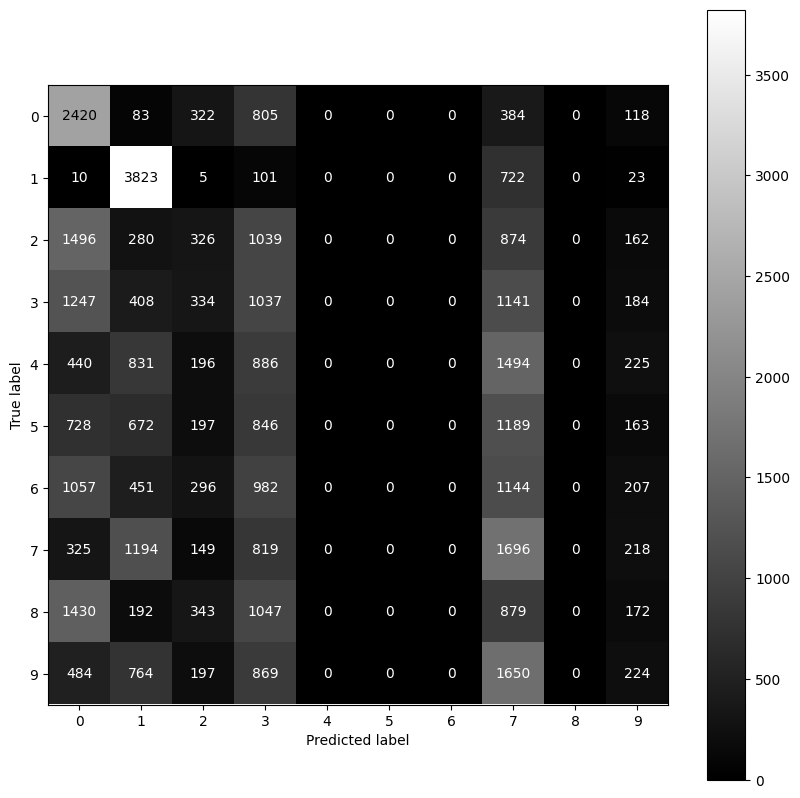

In [25]:
show_confusion_matrix(labels, ink_pred, ink_log_reg.classes_.astype(int), path="log_reg_ink_conf.png")

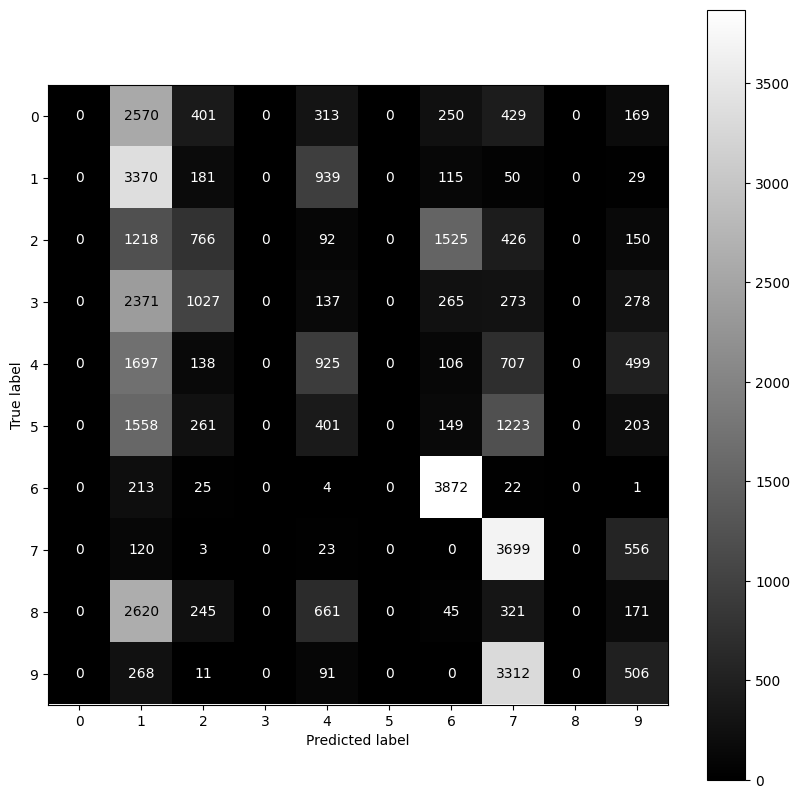

In [34]:
show_confusion_matrix(labels, angle_pred, angle_log_reg.classes_.astype(int), path="log_reg_angle_conf.png")

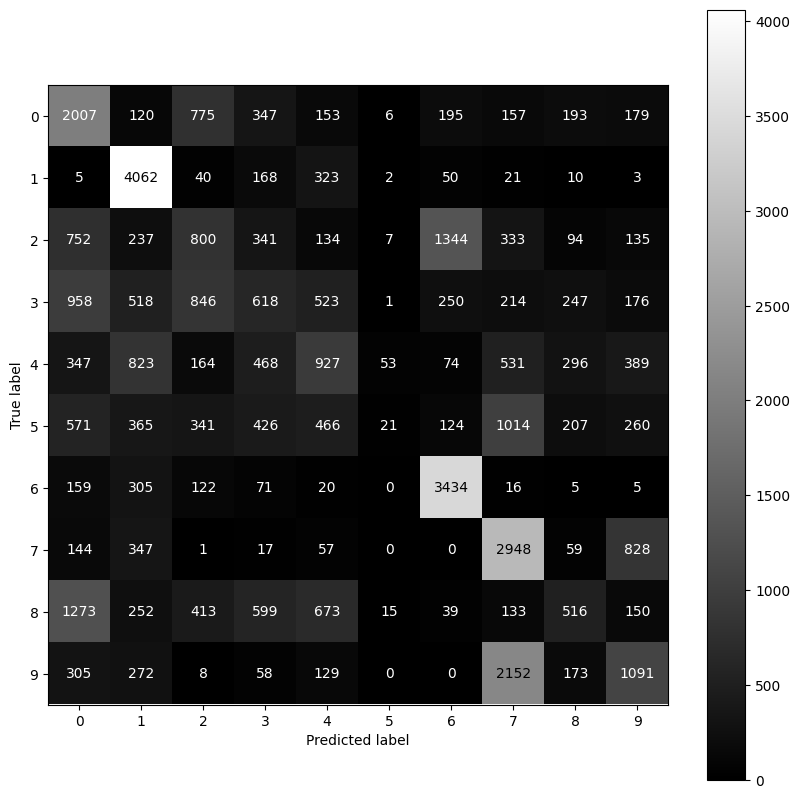

In [43]:
show_confusion_matrix(labels, both_pred, both_log_reg.classes_.astype(int), path="log_reg_both.png")

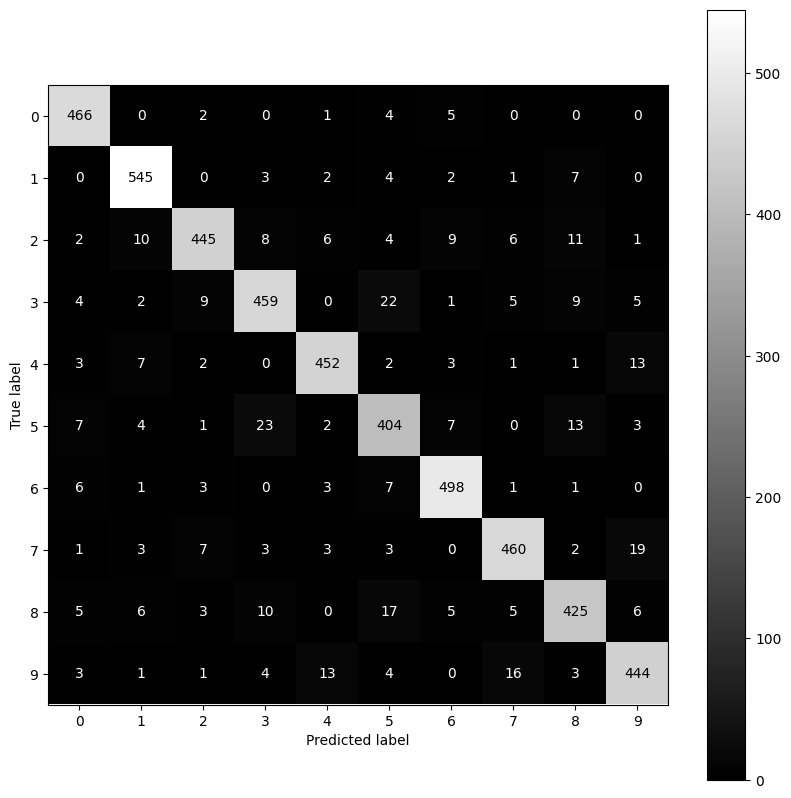

In [26]:
show_confusion_matrix(test_y, log_reg_pred, log_reg.classes_.astype(int), path="log_reg_conf.png")

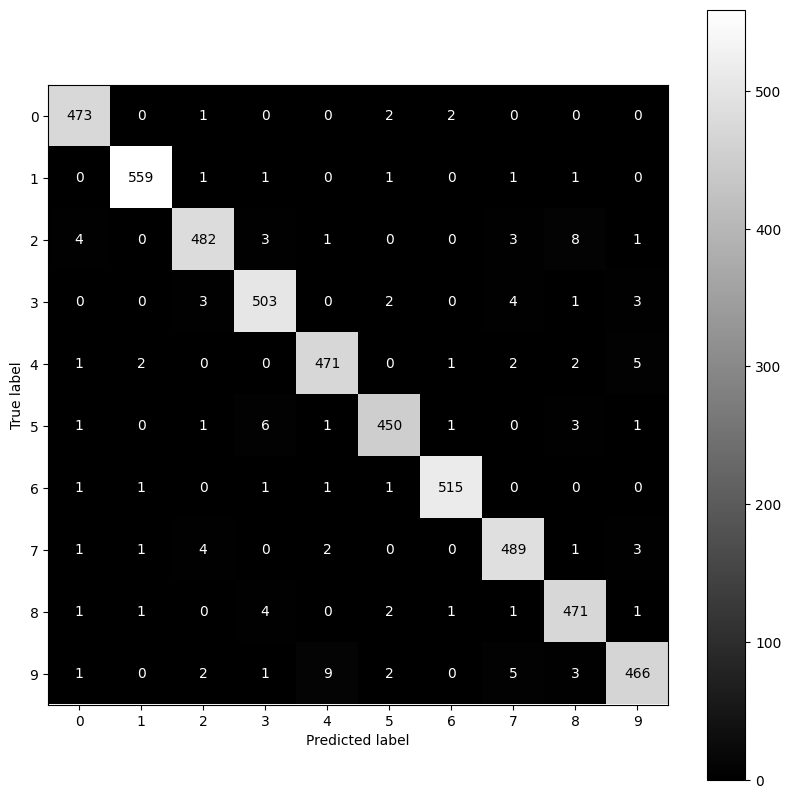

In [27]:
show_confusion_matrix(test_y, svm_pred, svm.classes_.astype(int), path="svm_conf.png")

In [28]:
def mcnemar_test(pred_y_a, pred_y_b, correct):
    def create_comparison_table(pred_y_a, pred_y_b, correct):
        correct_a = pred_y_a == correct
        correct_b = pred_y_b == correct
        return confusion_matrix(correct_a, correct_b)
    table = create_comparison_table(pred_y_a, pred_y_b, correct)
    print(table)
    b = table[0][1]
    c = table[1][0]
    if b == 0 and c == 0:
        x2 = 0
    else:
        x2 = ((b - c) ** 2) / (b + c)
    p = stats.chi2.sf(x2, df=1)
    return {"chi": x2, "df": 1, "p": p}


In [29]:
def show_all_misclassified(true_y, pred_y, cols=5, savefig=False, filename="plot.png"):
    wrongly_classified = np.arange(0, len(true_y))[true_y != pred_y]
    rows = len(wrongly_classified) // cols + 1
    fig = plt.figure(figsize=(25, 20))
    gs1 = gridspec.GridSpec(rows, cols)

    for idx, error in enumerate(wrongly_classified):
        ax = plt.subplot(gs1[idx])
        ax.imshow(digits[test_indices[error]].reshape(IMG_SIZE, IMG_SIZE))

        ax.axis('off')
        ax.text(0.5,-0.3, f"Idx: {error}, True Label: {true_y[error]}, Pred Label: {pred_y[error]}", size=10, ha="center", 
             transform=ax.transAxes)

    if savefig:
        plt.savefig(filename, dpi=100)
    plt.show()


In [30]:
def show_n_misclassified(true_y, pred_y, indices, cols=5, filename=""):
    fig = plt.figure(figsize=(25, 20))
    rows = len(indices) // cols + 1
    gs1 = gridspec.GridSpec(rows, cols)
    

    for idx, error_id in enumerate(indices):
        ax = plt.subplot(gs1[idx])
        ax.imshow(digits[test_indices[error_id]].reshape(IMG_SIZE, IMG_SIZE))

        ax.axis('off')
        ax.text(0.5,-0.3, f"True Label: {true_y[error_id]}, Pred Label: {pred_y[error_id]}", size=10, ha="center", 
             transform=ax.transAxes)

    if filename:
        plt.savefig(filename, dpi=100)
    plt.show()

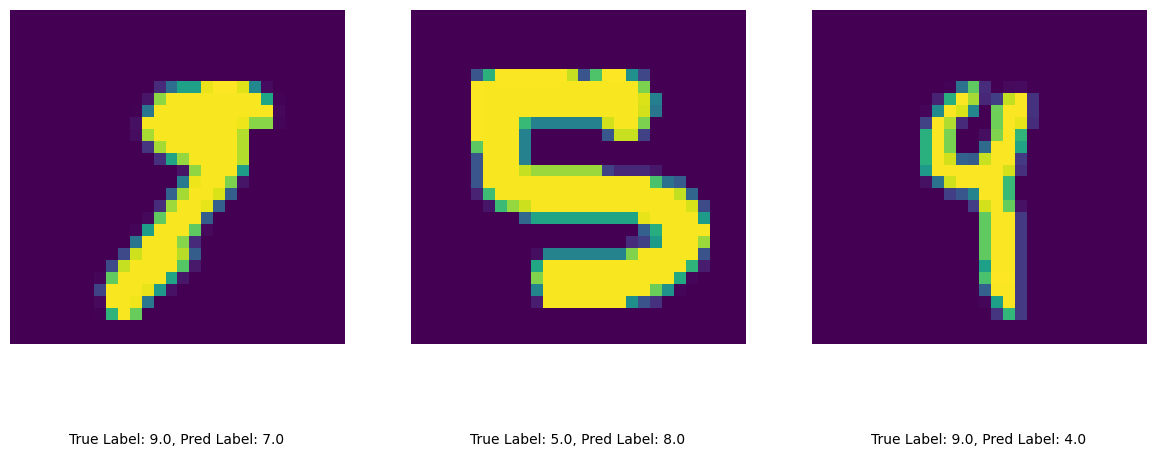

In [35]:
show_n_misclassified(test_y, svm_pred, [503, 2734, 629])

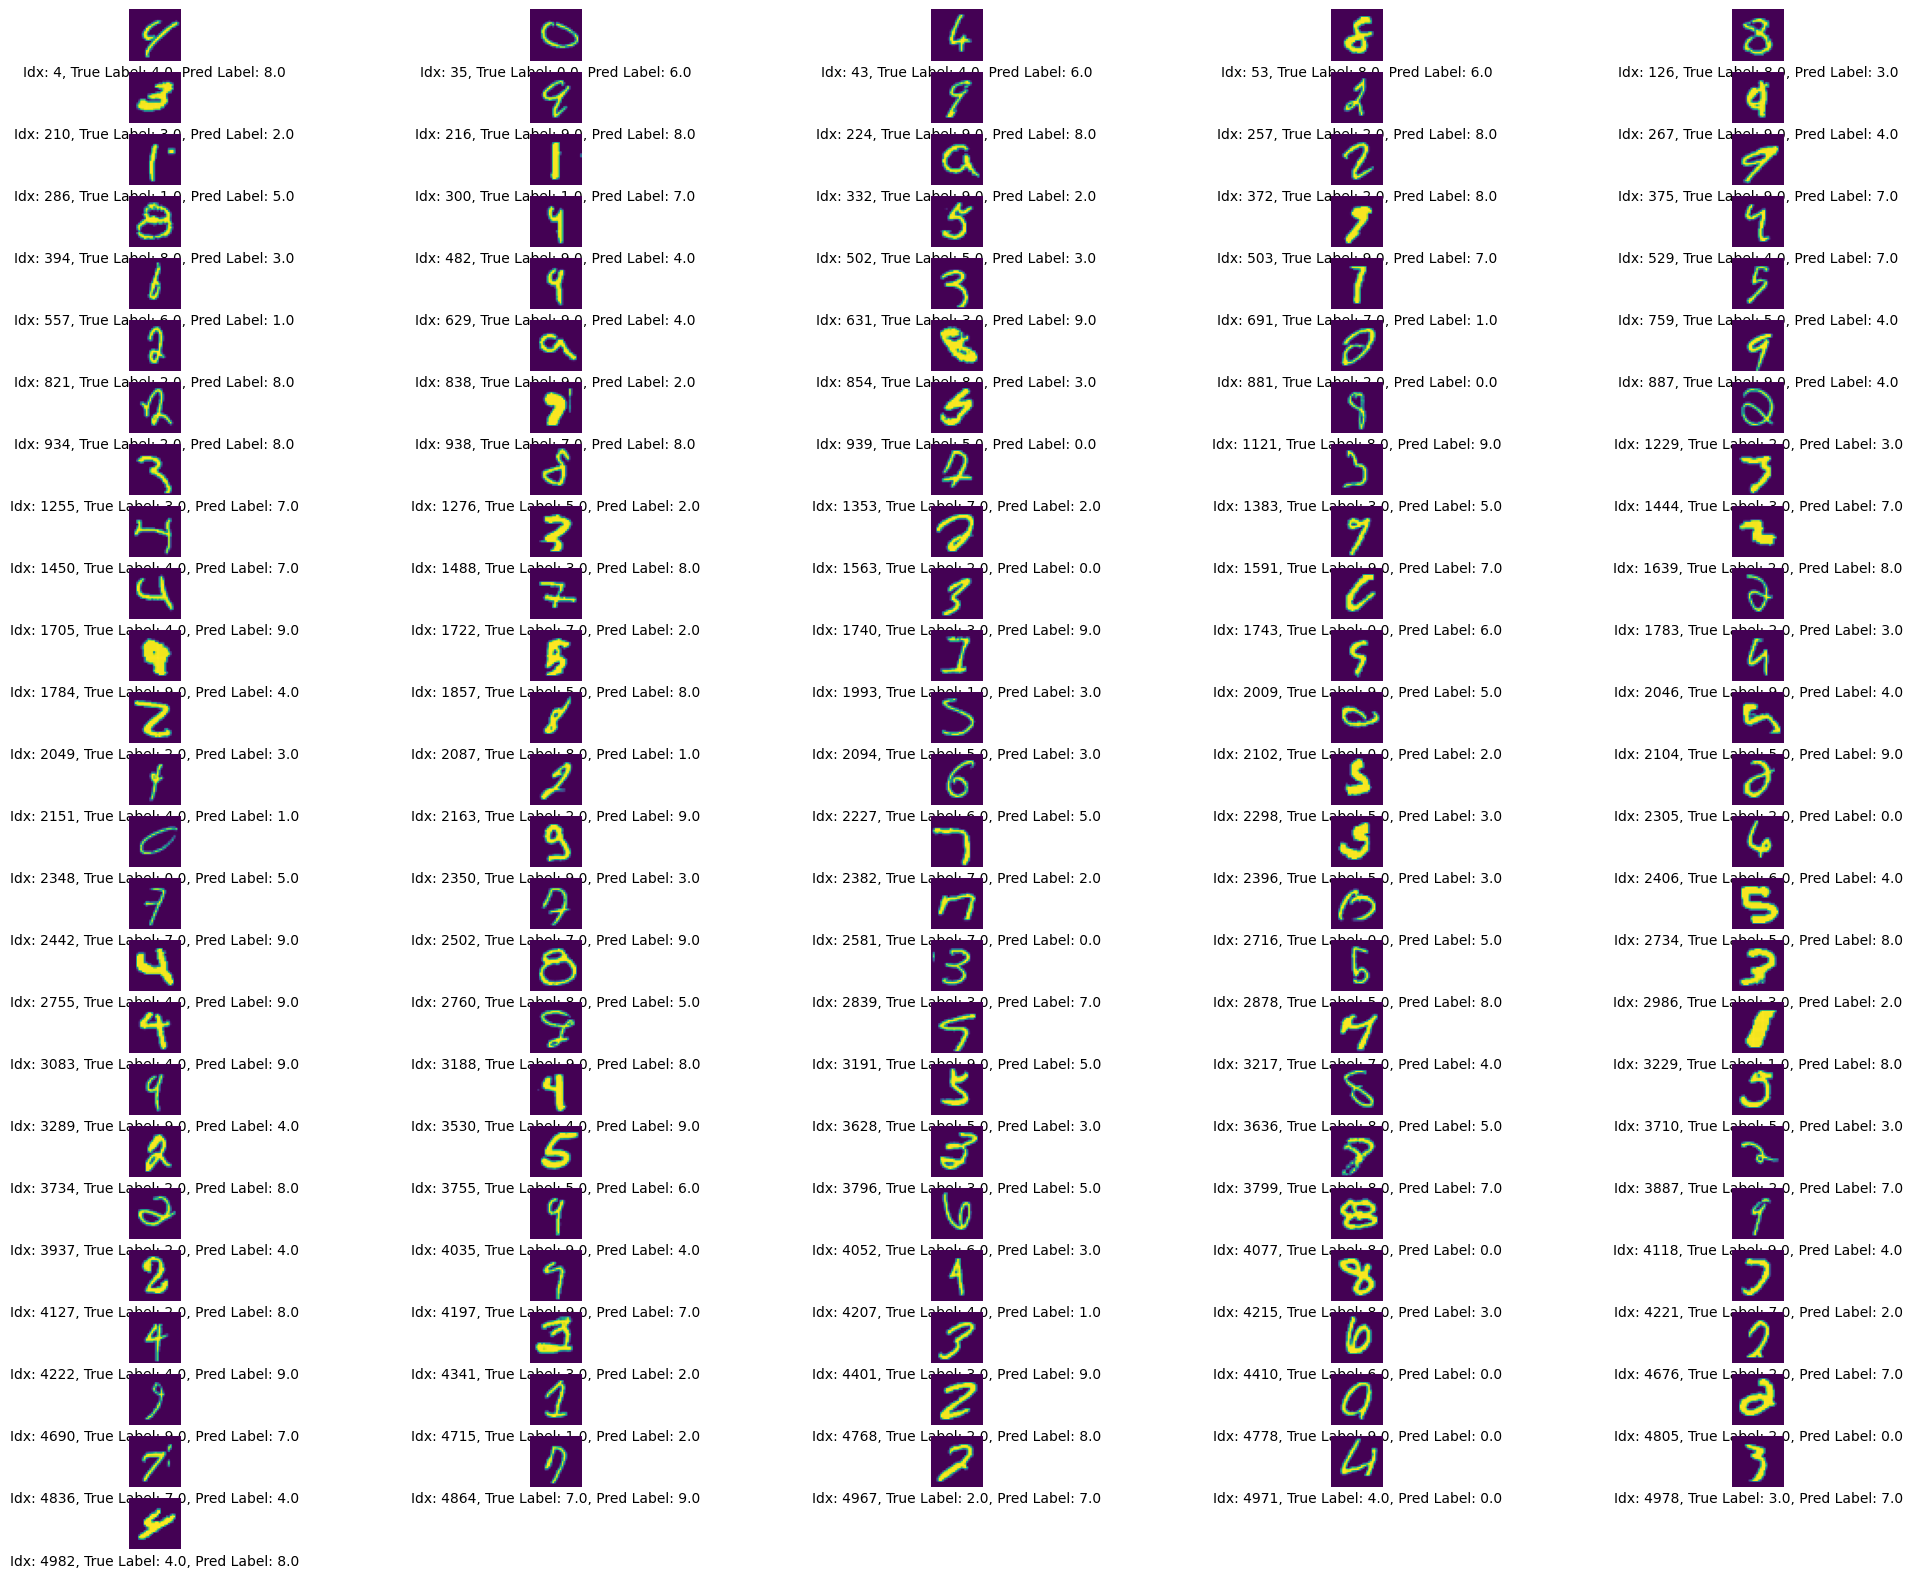

In [32]:
show_all_misclassified(test_y, svm_pred)

In [ ]:
show_all_misclassified(test_y, log_reg_pred, 20)

In [ ]:
mcnemar_test(svm_pred, log_reg_pred, test_y)

In [44]:
# Proportion of parameters that are set to zero in Logistic Regression
np.sum(log_reg.coef_ == 0) / np.array(log_reg.coef_.shape).prod()

0.6365819209039548